In [ ]:
import numpy as np
from PIL import Image
import os
import random

dir = 'eigenface_dataset/upload_dataset/'
files = os.listdir(dir)
random.shuffle(files)
filesa = [x for x in files if x[-5] == 'a']
filesb = [x for x in files if x[-5] == 'b']

##################
#for neutral faces
##################

#puts neutral faces into array facesNeutral
facesNeutral = np.zeros((31266, 100), dtype=int)
for i in range(100):
    img = np.asarray(Image.open(dir+filesa[i]))
    facesNeutral[:,i] = img.flatten()

#calculates the average neutral face
avgNeutral = facesNeutral.mean(axis=1)

#normalizes the faces
facesNeutralNormalized = np.zeros((31266, 100), dtype=float)
for x in range(len(facesNeutral[0])):
    facesNeutralNormalized[:, x] = np.subtract(facesNeutral[:, x], avgNeutral)

#gets the neutral face eigenface space matrix
covarNeutral = np.matmul(facesNeutralNormalized.T, facesNeutralNormalized)
eigenval, eigenvec = np.linalg.eig(covarNeutral)
order = eigenval.argsort()
eigenvec = eigenvec[order]

eigenFacesNeutral = np.matmul(facesNeutralNormalized, eigenvec)


##################
#for smiling faces
##################

#puts smiling faces into array facesSmile
facesSmile = np.zeros((31266, 100), dtype=int)
for i in range(100):
    img = np.asarray(Image.open(dir+filesb[i]))
    facesSmile[:,i] = img.flatten()

#calculates the average smiling face
avgSmiling = facesSmile.mean(axis=1)

#normalizes the faces
facesSmileNormalized = np.zeros((31266, 100), dtype=float)
for x in range(len(facesSmile[0])):
    facesSmileNormalized[:, x] = np.subtract(facesSmile[:, x], avgSmiling)

#gets the smiling face eigenface space matrix
covarSmiling = np.matmul(facesSmileNormalized.T, facesSmileNormalized)
eigenval, eigenvec = np.linalg.eig(covarSmiling)
order = eigenval.argsort()
eigenvec = eigenvec[order]

eigenFacesSmiling = np.matmul(facesSmileNormalized, eigenvec)


In [ ]:
#Plot singular data values
u, s, v = np.linalg.svd(covarNeutral)
import matplotlib.pyplot as plt

plt.plot(range(len(s)), s)


u, s, v = np.linalg.svd(covarSmiling)
plt.plot(range(len(s)), s)

In [ ]:
#plot top ten eigenfaces
for i in range(10):
    img = eigenFacesNeutral[:, i]
    img = img.reshape((193, 162))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

for i in range(10):
    img = eigenFacesSmiling[:, i]
    img = img.reshape((193, 162))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()



In [ ]:
#mean squared error calculation
def mse(x, x_guess):
    return np.square(np.subtract(x,x_guess)).mean()

#gets a testing image from neutral and smiling
testNeutral = np.asarray(Image.open(dir+filesa[120])).flatten()
testSmiling = np.asarray(Image.open(dir+filesb[120])).flatten()


#reconstructs faces using different number of principal components
#####################
#parameters to change depending on the problem
eigenfaces = eigenFacesSmiling
img = testSmiling.reshape((193, 162))
avg = avgSmiling
testFace = testSmiling
#####################

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()
errors = []
for i in range(1, 11):
    eigenfaces_k = eigenfaces[:, :i*10]
    P = np.linalg.pinv(eigenfaces_k)
    w = np.matmul(P, testFace - avg)
    face_reconstructed = np.matmul(eigenfaces_k, w) + avg
    errors.append(mse(testFace, face_reconstructed))

    img = face_reconstructed.reshape((193, 162))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()
    
plt.plot(list(range(10, 110, 10)), errors)
plt.xlabel("Number of eigenfaces")
plt.ylabel("Mean Squared Error")

In [31]:
#gets 60 random testing faces
testingFaces = np.zeros((31266, 60), dtype=int)
labels = np.zeros(60, dtype=int)
PCs = 40

import random
for i in range(60):
    flip = random.randint(0,1)
    if flip == 0:
        img = np.asarray(Image.open(dir+filesa[i + 100]))
    else:
        img = np.asarray(Image.open(dir+filesb[i + 100]))
        labels[i] = 1
    testingFaces[:,i] = img.flatten()

errors = []
for i in range(len(testingFaces[0])):
    testFace = testingFaces[:, i]

    #neutral reconstruction
    eigenfacesNeutral_k = eigenFacesNeutral[:, :PCs]
    P = np.linalg.pinv(eigenfacesNeutral_k)
    w = np.matmul(P, testFace - avgNeutral)
    face_reconstructed_neutral = np.matmul(eigenfacesNeutral_k, w) + avgNeutral

    #smiling reconstruction
    eigenFacesSmiling_k = eigenFacesSmiling[:, :PCs]
    P = np.linalg.pinv(eigenFacesSmiling_k)
    w = np.matmul(P, testFace - avgSmiling)
    face_reconstructed_smile = np.matmul(eigenFacesSmiling_k, w) + avgSmiling

    #classification
    #0 = neutral
    #1 = smiling
    errorNeutral = mse(testFace, face_reconstructed_neutral)
    errorSmiling = mse(testFace, face_reconstructed_smile)
    faceClass = 0
    if errorNeutral > errorSmiling:
        faceClass = 1

    #validation
    if faceClass != labels[i]:
        errors.append(i)



Smiling accuracy: 96.88%
Neutral accuracy: 92.86%
face classified as neutral:


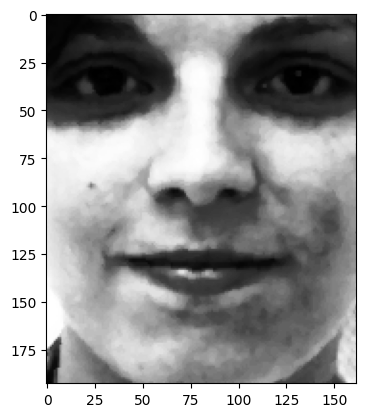

face classified as neutral:


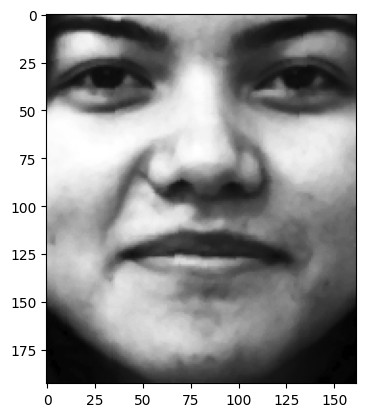

face classified as smiling:


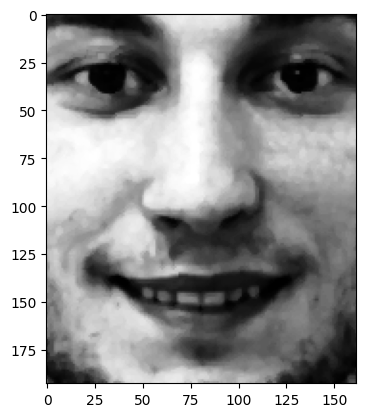

In [35]:
##error report
nSmiling = np.count_nonzero(labels == 1)
nNeutral = np.count_nonzero(labels == 0)

smilingErrors = [labels[i] for i in errors].count(1)
neutralErrors = [labels[i] for i in errors].count(0)

print("Smiling accuracy: " + str(round(1 - smilingErrors/nSmiling, 4) * 100) +"%")
print("Neutral accuracy: " + str(round(1 - neutralErrors/nNeutral, 4) * 100) +"%")

for i in errors:
    if labels[i] == 0:
        print("face classified as neutral:")
    else:
        print("face classified as smiling:")
    img = testingFaces[:, i].reshape((193, 162))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()
